# Biweekly Report 4
# Jacob Tiede
## Revisiting LSTMs/Addressing Feedback from Biweekly Report 2
In this notebook I will attempt to solve some of the problems associated with my prior biweekly report. Namely, I will attempt to increase the GPU utilization of my LSTM, and identify what might be causing some of the errors in my model. To start we will copy the code I did from that week:


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("Is a GPU available?")
torch.cuda.is_available()

Is a GPU available?


True

In [4]:
#Let's load the data into python
trainData = pd.read_csv("./Data/Tweet_train.csv")
#To get an idea of what the data contains we will print the first few rows:
print(trainData.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [5]:
#extract the target:
trainTarget = trainData['target'].to_numpy()
#We'll only use the text to train (no keyword or id)
trainText = trainData['text'].to_numpy()
from sklearn.model_selection import train_test_split
trainText, testText, trainTarget, testTarget = train_test_split(trainText, trainTarget, test_size=0.1, random_state=4)

testTarget = torch.from_numpy(testTarget).cuda()
trainTarget = torch.from_numpy(trainTarget).cuda()

In [6]:
trainText.shape

(6851,)

In [7]:
#We now need to both separate all of our sentences into words and represent them with a vector, we will do this with a class

#This function takes a string and separates it into words
def sentToWords(text):
    words = []
    temp = ""
    for i in text:
        if i != " ":
            temp = temp + i
        else:
            words.append(temp)
            temp = ""
    words.append(temp)
    return words

#takes a vector of strings and splits them into words, which then become a vocab dictionary with an index mapping
def splitSentences(text):
    words = []
    temp = ""
    for para in text:
        for i in para:
            if i != " ":
                temp = temp + i
            else:
                words.append(temp)
                temp = ""
        words.append(temp)
    mapping = {}
    k = 0
    for word in words:
        if word not in mapping.keys():
            mapping[word] = k
            k+=1
    return mapping
vocab = splitSentences(trainText)

#converts a sentence to a list of indexes based on a vocab dictionary
def sentenceToIdx(sent, mapping):
    temp = sentToWords(sent)
    mappedSentence = []
    for i in temp:
        if i in mapping.keys():
            mappedSentence.append(mapping[i])
        else:
            mappedSentence.append(len(mapping.keys()))
    return torch.tensor(mappedSentence).view(1,-1)

### Making it Faster
To do this we can increase the batch size:

In [8]:
#Let's get a histogram of sentence length to see if tweets tend to be similarly sized:
temp = []
for i in range(trainText.shape[0]):
    temp.append(len(sentToWords(trainText[i])))


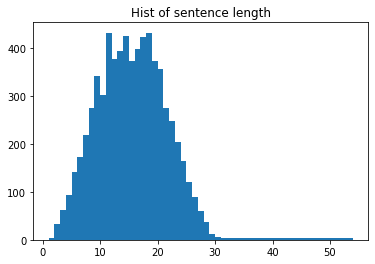

In [9]:
plt.hist(temp, bins = np.unique(np.array(temp)))
plt.title("Hist of sentence length")
plt.show()

In order to increase GPU usage we will try to find sentences of the same length and group them together, then feed them into the model. As we can see from the above histogram there should be plenty of opportunities to do this, so let's give it a try:

In [10]:
#We now need to both separate all of our sentences into words and represent them with a vector, we will do this with a class

#This function takes a string and separates it into words
def sentToWords(text):
    words = []
    temp = ""
    for i in text:
        if i != " ":
            temp = temp + i
        else:
            words.append(temp)
            temp = ""
    words.append(temp)
    return words

#takes a vector of strings and splits them into words, which then become a vocab dictionary with an index mapping
def splitSentences(text):
    words = []
    temp = ""
    for para in text:
        for i in para:
            if i != " ":
                temp = temp + i
            else:
                words.append(temp)
                temp = ""
        words.append(temp)
    mapping = {}
    k = 0
    for word in words:
        if word not in mapping.keys():
            mapping[word] = k
            k+=1
    return mapping
vocab = splitSentences(trainText)

#converts a sentence to a list of indexes based on a vocab dictionary
def sentenceToIdx(sent, mapping):
    temp = sentToWords(sent)
    mappedSentence = []
    for i in temp:
        if i in mapping.keys():
            mappedSentence.append(mapping[i])
        else:
            mappedSentence.append(len(mapping.keys()))
    return torch.tensor(mappedSentence).view(1,-1)

#create the LSTM Classifier, see https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.tagset_size = tagset_size
        #the dimension of the hidden state of our LSTM
        self.hidden_dim = hidden_dim
        #create the trainable word embedding
        self.word_embeddings = nn.Embedding(vocab_size+1, embedding_dim)
        
        #we only have a single LSTM layer in this model
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        #from the pytorch tutorial, they were trying to tag words with things like "noun" or "verb", but I will only use the final output, so a better name might
        #be hidden to prediction, but for the sake of following the notation of the tutorial I will keep the naming
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        
    def forward(self, sentence):
        #embed the word vectors into a smaller dimension space
        embeds = self.word_embeddings(sentence).view(sentence.shape[1], self.batch_size, -1)
        #send this through our LSTM layer
        lstm_out, _ = self.lstm(embeds)
        #tag space is the "tags" of each word, but remember that we only actually need to apply this neural net to the last "word" in the sentence (the final output of the LSTM)
        tag_space = self.hidden2tag(lstm_out.view(self.batch_size,sentence.shape[1], -1)[:,sentence.shape[1]-1,:])
        out = torch.sigmoid(tag_space)
        return out
    def setBatchSize(self, x):
        self.batch_size = x
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()



LSTMClassifier(
  (word_embeddings): Embedding(34063, 13)
  (lstm): LSTM(13, 6)
  (hidden2tag): Linear(in_features=6, out_features=1, bias=True)
)

In [9]:
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()
#train the model similarly to how we have before
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epochs = 50
#Batch size will not always be 64, this is more like max batch size
batch_size = 64
for epoch in range(epochs):
    running_loss = 0
    temp = torch.randperm(trainText.shape[0])
    trainTarget = trainTarget[temp]
    trainText = trainText[temp]
    
    moreData = True
    j = 0
    
    #keep a list of unprocessed indicies
    validInd = list(range(trainText.shape[0]))
    while moreData:
        if validInd[j] != -1:
            optimizer.zero_grad()
            words = len(sentToWords(trainText[j]))
            #look for sentences that we have not already process
            i = j+1
            #we know that we will need to include j
            temp = [sentenceToIdx(trainText[j], vocab).cuda()]
            targetInd = [j]
            #look through the whole list of sentences for similarly sized sentences to j, if we get batch_size in temp then stop, or if we have iterated through
            #the whole list
            while len(temp) < batch_size and i < trainText.shape[0]:
                #if we have an unprocessed index
                if validInd[i] != -1:
                    tempWords = len(sentToWords(trainText[i]))
                    if tempWords == words:
                        temp.append(sentenceToIdx(trainText[i], vocab).cuda())
                        validInd[i] = -1
                        targetInd.append(i)
                i+=1
            #temp was a list of tensors so we can just cat those together, then the rest is the same as in my previous biweekly report
            input = torch.cat(temp, dim = 0)
            model.setBatchSize(input.shape[0])
            output = model(input)
            temp = trainTarget[targetInd]
            loss = criterion(output.float(), temp.float().view(temp.shape[0],1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        j+=1
        if j == trainText.shape[0] -1 and epoch%10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / trainText.shape[0]))
            acc = 0
            model.setBatchSize(1)
            for k in range(int(testText.shape[0])):
                input = sentenceToIdx(testText[k], vocab).cuda()
                output = model(input)
                if output >= .5:
                    output = 1
                else:
                    output = 0
                if output == testTarget[k]:
                    acc += 1
            print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))
        if j == trainText.shape[0]-1:
            moreData = False
print('Finished Training')

[10,  6851] loss: 0.013
Test set accuracy for this epoch: 0.4816272965879265
[20,  6851] loss: 0.012
Test set accuracy for this epoch: 0.5485564304461942
[30,  6851] loss: 0.012
Test set accuracy for this epoch: 0.5643044619422573
[40,  6851] loss: 0.012
Test set accuracy for this epoch: 0.5643044619422573
[50,  6851] loss: 0.012
Test set accuracy for this epoch: 0.5656167979002624
Finished Training


In [12]:
torch.save(model.state_dict(), './lstmModel')

In [15]:
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()

LSTMClassifier(
  (word_embeddings): Embedding(34063, 13)
  (lstm): LSTM(13, 6)
  (hidden2tag): Linear(in_features=6, out_features=1, bias=True)
)

In [13]:
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.load_state_dict(torch.load('./lstmModel'))
model.cuda().eval()

LSTMClassifier(
  (word_embeddings): Embedding(34063, 13)
  (lstm): LSTM(13, 6)
  (hidden2tag): Linear(in_features=6, out_features=1, bias=True)
)

In [16]:
acc = 0
model.setBatchSize(1)
for k in range(int(testText.shape[0])):
    input = sentenceToIdx(testText[k], vocab).cuda()
    output = model(input)
    if output >= .5:
        output = 1
    else:
        output = 0
    if output == testTarget[k]:
        acc += 1
print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))


Test set accuracy for this epoch: 0.5656167979002624


As you can see this is much faster, but the test set accuracy has suffered. It is pertinent to first ask if we have implement this batch process correctly, so to this end I will set batch size to 1 and then to 2, to see if we reporduce my results from the seecond biweekly report:

In [30]:
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()
#train the model similarly to how we have before
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epochs = 50
batch_size = 1
for epoch in range(epochs):
    running_loss = 0
    temp = torch.randperm(trainText.shape[0])
    trainTarget = trainTarget[temp]
    trainText = trainText[temp]
    
    moreData = True
    j = 0
    
    validInd = list(range(trainText.shape[0]))
    while moreData:
        if validInd[j] != -1:
            optimizer.zero_grad()
            words = len(sentToWords(trainText[j]))
            i = j+1
            temp = [sentenceToIdx(trainText[j], vocab).cuda()]
            targetInd = [j]
            while len(temp) < batch_size and i < trainText.shape[0]:
                if validInd[i] != 0:
                    tempWords = len(sentToWords(trainText[i]))
                    if tempWords == words:
                        temp.append(sentenceToIdx(trainText[i], vocab).cuda())
                        validInd[i] = -1
                        targetInd.append(i)
                i+=1  
            input = torch.cat(temp, dim = 0)
            model.setBatchSize(input.shape[0])
            output = model(input)
            temp = trainTarget[targetInd]
            loss = criterion(output.float(), temp.float().view(temp.shape[0],1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        j+=1
        if j == trainText.shape[0] -1 and epoch%10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / trainText.shape[0]))
            acc = 0
            model.setBatchSize(1)
            for k in range(int(testText.shape[0])):
                input = sentenceToIdx(testText[k], vocab).cuda()
                output = model(input)
                if output >= .5:
                    output = 1
                else:
                    output = 0
                if output == testTarget[k]:
                    acc += 1
            print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))
        if j == trainText.shape[0]-1:
            moreData = False
print('Finished Training')

[10,  6851] loss: 0.561
Test set accuracy for this epoch: 0.60498687664042
[20,  6851] loss: 0.404
Test set accuracy for this epoch: 0.7060367454068242
[30,  6851] loss: 0.283
Test set accuracy for this epoch: 0.7165354330708661
[40,  6851] loss: 0.193
Test set accuracy for this epoch: 0.7401574803149606
[50,  6851] loss: 0.128
Test set accuracy for this epoch: 0.7244094488188977
Finished Training


In [32]:
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()
#train the model similarly to how we have before
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epochs = 50
batch_size = 2
for epoch in range(epochs):
    running_loss = 0
    temp = torch.randperm(trainText.shape[0])
    trainTarget = trainTarget[temp]
    trainText = trainText[temp]
    
    moreData = True
    j = 0
    
    validInd = list(range(trainText.shape[0]))
    while moreData:
        if validInd[j] != -1:
            optimizer.zero_grad()
            words = len(sentToWords(trainText[j]))
            i = j+1
            temp = [sentenceToIdx(trainText[j], vocab).cuda()]
            targetInd = [j]
            while len(temp) < batch_size and i < trainText.shape[0]:
                if validInd[i] != 0:
                    tempWords = len(sentToWords(trainText[i]))
                    if tempWords == words:
                        temp.append(sentenceToIdx(trainText[i], vocab).cuda())
                        validInd[i] = -1
                        targetInd.append(i)
                i+=1  
            input = torch.cat(temp, dim = 0)
            model.setBatchSize(input.shape[0])
            output = model(input)
            temp = trainTarget[targetInd]
            loss = criterion(output.float(), temp.float().view(temp.shape[0],1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        j+=1
        if j == trainText.shape[0] -1 and epoch%10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / trainText.shape[0]))
            acc = 0
            model.setBatchSize(1)
            for k in range(int(testText.shape[0])):
                input = sentenceToIdx(testText[k], vocab).cuda()
                output = model(input)
                if output >= .5:
                    output = 1
                else:
                    output = 0
                if output == testTarget[k]:
                    acc += 1
            print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))
        if j == trainText.shape[0]-1:
            moreData = False
print('Finished Training')

[10,  6851] loss: 0.322
Test set accuracy for this epoch: 0.5879265091863517
[20,  6851] loss: 0.275
Test set accuracy for this epoch: 0.6535433070866141
[30,  6851] loss: 0.228
Test set accuracy for this epoch: 0.6679790026246719
[40,  6851] loss: 0.185
Test set accuracy for this epoch: 0.6771653543307087
[50,  6851] loss: 0.148
Test set accuracy for this epoch: 0.6811023622047244
Finished Training


We were able to reproduce the accuracy from the first biweekly reports in both these cases (or close to the same accuracy). There are several potential causes for this: we could be observing the so called "generalizability gap" that I discussed in my second biweekly report (see the ghost batch norm section of that document), but I think that is somewhat less likely given how low the loss is for the batch size = 64 case. What I think is more likely is that we are overfitting to that data. This is probably because we are feeding the model sentences of the same length in batches. Sentences of similar length are probably related to each other to an extent, so we are probably encouraging the model to overfit to this knowledge. I tried to solve this through sampling with replacement (rather than forcing the model to look at each sample once per epoch), but this made the overfitting worse. I'm not quite sure how to solve this since I think it is intrinsic to the fact that I'm using a larger batch size. I'm going to close this issue for now since my implementation does speed up training, but some sort of regularization is in order to keep the model from overfitting.
### Looking at the Mistakes the Model Makes:
First we'll need to retrain the model using batch size = 1 to get similar accuracy:


In [7]:
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()
#train the model similarly to how we have before
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epochs = 50
batch_size = 1
for epoch in range(epochs):
    running_loss = 0
    temp = torch.randperm(trainText.shape[0])
    trainTarget = trainTarget[temp]
    trainText = trainText[temp]
    
    moreData = True
    j = 0
    
    validInd = list(range(trainText.shape[0]))
    while moreData:
        if validInd[j] != -1:
            optimizer.zero_grad()
            words = len(sentToWords(trainText[j]))
            i = j+1
            temp = [sentenceToIdx(trainText[j], vocab).cuda()]
            targetInd = [j]
            while len(temp) < batch_size and i < trainText.shape[0]:
                if validInd[i] != 0:
                    tempWords = len(sentToWords(trainText[i]))
                    if tempWords == words:
                        temp.append(sentenceToIdx(trainText[i], vocab).cuda())
                        validInd[i] = -1
                        targetInd.append(i)
                i+=1  
            input = torch.cat(temp, dim = 0)
            model.setBatchSize(input.shape[0])
            output = model(input)
            temp = trainTarget[targetInd]
            loss = criterion(output.float(), temp.float().view(temp.shape[0],1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        j+=1
        if j == trainText.shape[0] -1 and epoch%10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / trainText.shape[0]))
            acc = 0
            model.setBatchSize(1)
            for k in range(int(testText.shape[0])):
                input = sentenceToIdx(testText[k], vocab).cuda()
                output = model(input)
                if output >= .5:
                    output = 1
                else:
                    output = 0
                if output == testTarget[k]:
                    acc += 1
            print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))
        if j == trainText.shape[0]-1:
            moreData = False
print('Finished Training')

[10,  6851] loss: 0.557
Test set accuracy for this epoch: 0.6797900262467191
[20,  6851] loss: 0.401
Test set accuracy for this epoch: 0.7230971128608924
[30,  6851] loss: 0.289
Test set accuracy for this epoch: 0.7270341207349081
[40,  6851] loss: 0.199
Test set accuracy for this epoch: 0.7335958005249343
[50,  6851] loss: 0.133
Test set accuracy for this epoch: 0.7283464566929134
Finished Training


In [9]:
# let's find the sentences that it misclassifies:
l = 0
numSentencesToPrint = 10
for k in range(int(testText.shape[0])):
    input = sentenceToIdx(testText[k], vocab).cuda()
    output = model(input)
    if output >= .5:
        output = 1
    else:
        output = 0
    if output != testTarget[k] and l < numSentencesToPrint:
        print("Misclassified Sentence:")
        print(testText[k])
        print("Classified as: " + str(output))
        l+=1

Misclassified Sentence:
#Cowboys: George: Injury woes took Claiborne from first round to trying to stick around; can he do it?:  http://t.co/12giQbVLYs
Classified as: 1
Misclassified Sentence:
Bridge collapse not natural calamity but man-made: MPP lambasts Congress - KanglaOnline http://t.co/jp9XylA3C5  #Yugvani
Classified as: 0
Misclassified Sentence:
hurricane?? sick!
Classified as: 0
Misclassified Sentence:
Beautiful lightning as seen from plane window http://t.co/5CwUyLnFUm http://t.co/1tyYqFz13D
Classified as: 1
Misclassified Sentence:
Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf
Classified as: 0
Misclassified Sentence:
On the 2nd year the officer team running the club collapsed. A few influential members betrayed everyone's trust severing the community.
Classified as: 1
Misclassified Sentence:
ÛÏYou see the devastation &amp; itÛªs shocking.ÛÏ  Firefighters continue to battle flames in California. benstracy reports Û_
Classified as: 0
Misclassified Sente

It looks like one problem is the brevity of the tweet, shorter tweets (like the word "Meltdown" with no other context) are hard to classify (for obvious reasons). Interestingly, it looks like most of these misclassifications are reasonable, but one interesting tweet is "ÛÏYou see the devastation &amp; itÛªs shocking.ÛÏ  Firefighters continue to battle flames in California. benstracy reports Û_" which is a disaster tweet (obviously if you ignore the strange characters), but the model still misclassified it. This is interesting because it looks like the low occurance of tweets like this (with strange characters) might have confused the model since these are probably uncommon in general. This means that it sees that as unlike anything it has seen before, so it probably defaults to a classification of 0 since it can't tell that there is a disaster. I'm not quite sure how this problem is typically solved, but word embeddings (which we've already implemented) seem to actually do an okay job at this correction (or rather ignoring misspelled words all together), but it would be better to never have the misspelling in the first place. One method of solving this is detailed by https://towardsdatascience.com/correcting-your-spelling-error-with-4-operations-50bcfd519bb8. This method is basically just doing simple operations on a given word (like adding or deleting a character) and then seeing which candidate word created by this process has the highest likelihood of being within some corpus of words. An implementation of this can be found here: https://pypi.org/project/pyspellchecker/, let's first replicate some of the documentation:

In [3]:
from spellchecker import SpellChecker
#This example from the documentation at: https://pypi.org/project/pyspellchecker/
spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))


happening
{'henning', 'happening', 'penning'}


Looks like it is working, let's see if running our dataset through this spell checker will help our results:

In [31]:
def fixSentence(sentence):
    words = sentToWords(sentence)
    misspelled = spell.unknown(words)
    for i in range(len(words)):
        for j in misspelled:
            if words[i] == j:
                words[i] = spell.correction(words[i])
    string = ""
    for i in words:
        string += i + " "
    return string
test = "ÛÏYou see the devastation &amp; itÛªs shocking.ÛÏ  Firefighters continue to battle flames in California. benstracy reports Û_"
fixSentence(test)

'ÛÏYou see the devastation camp itÛªs shocking.ÛÏ a Firefighters continue to battle flames in California. benstracy reports Û_ '

It's not great, but it looks better than before, so let's run the whole data set through:

In [32]:
import progressbar
with progressbar.ProgressBar(max_value=trainText.shape[0]-1) as bar:
    for i in range(trainText.shape[0]):
        trainText[i] = fixSentence(trainText[i])
        bar.update(i)
with progressbar.ProgressBar(max_value=testText.shape[0]-1) as bar:
    for i in range(testText.shape[0]):
        testText[i] = fixSentence(testText[i])
        bar.update(i)

100% (6850 of 6850) |####################| Elapsed Time: 0:56:21 Time:  0:56:21
100% (761 of 761) |######################| Elapsed Time: 0:06:20 Time:  0:06:20


Now we can attempt to train the model:

In [33]:
vocab = splitSentences(trainText)
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()
#train the model similarly to how we have before
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epochs = 50
batch_size = 1
for epoch in range(epochs):
    running_loss = 0
    temp = torch.randperm(trainText.shape[0])
    trainTarget = trainTarget[temp]
    trainText = trainText[temp]
    
    moreData = True
    j = 0
    
    validInd = list(range(trainText.shape[0]))
    while moreData:
        if validInd[j] != -1:
            optimizer.zero_grad()
            words = len(sentToWords(trainText[j]))
            i = j+1
            temp = [sentenceToIdx(trainText[j], vocab).cuda()]
            targetInd = [j]
            while len(temp) < batch_size and i < trainText.shape[0]:
                if validInd[i] != 0:
                    tempWords = len(sentToWords(trainText[i]))
                    if tempWords == words:
                        temp.append(sentenceToIdx(trainText[i], vocab).cuda())
                        validInd[i] = -1
                        targetInd.append(i)
                i+=1  
            input = torch.cat(temp, dim = 0)
            model.setBatchSize(input.shape[0])
            output = model(input)
            temp = trainTarget[targetInd]
            loss = criterion(output.float(), temp.float().view(temp.shape[0],1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        j+=1
        if j == trainText.shape[0] -1 and epoch%10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / trainText.shape[0]))
            acc = 0
            model.setBatchSize(1)
            for k in range(int(testText.shape[0])):
                input = sentenceToIdx(testText[k], vocab).cuda()
                output = model(input)
                if output >= .5:
                    output = 1
                else:
                    output = 0
                if output == testTarget[k]:
                    acc += 1
            print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))
        if j == trainText.shape[0]-1:
            moreData = False
print('Finished Training')

[10,  6851] loss: 0.608
Test set accuracy for this epoch: 0.6509186351706037
[20,  6851] loss: 0.440
Test set accuracy for this epoch: 0.6942257217847769
[30,  6851] loss: 0.312
Test set accuracy for this epoch: 0.7086614173228346
[40,  6851] loss: 0.211
Test set accuracy for this epoch: 0.6942257217847769
[50,  6851] loss: 0.139
Test set accuracy for this epoch: 0.6902887139107612
Finished Training


It looks like spell checking really didn't make that much of a difference, probably due to the fact that we are using word embeddings already. This leads me to believe that the lower accuracy is more likely due to the way that our neural network is structured rather than the data itself. Even though LSTMs have made leaps and bounds in terms of remembering the whole sentence, it still is not an ideal model. I've heard that some more modern models like transformers are better at this, but for now I'm going to leave this analysis here since I believe I have addressed the feedback given to me.